# Image Offsets: Find stars

This notebook combines the procedures developed in `Background.ipynb` and `White_light_images.ipynb` notebooks to build images suitable for star finding. Then it applies `photutils` tools to find star images and build  tables with centroid locations. 

There is also a statistical analysis to see how star shapes depend on the RGB normalization coefficients. 

Later we proceed to find stars in a few contiguous images in the sequence, to see how:
 - to correlate the detections that are stored in separate tables;
 - to keep track of the offsets from each n-th image to the reference n=0 image
 
There is code to save the offsets table to a FITS file.
 
No flat field, bias, or dark calibrations are required here. Note that, for the Sony Alpha camera used to get these data sets, they are not likely to be ever needed anywhere.

In [1]:
%pylab notebook
%matplotlib notebook

import os

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from astropy.table import Table, vstack
from astropy.io import fits
from astropy.stats import SigmaClip

import photutils
from photutils import Background2D, ModeEstimatorBackground, DAOStarFinder, CircularAperture

import rawpy

Populating the interactive namespace from numpy and matplotlib


In [2]:
# parameters for background subtraction and star finding
bkg_sigma = 3.0
bkg_cell_footprint = (100, 100)
bkg_filter = (5, 5)
dao_fwhm = 3.0
dao_threshold = 10.

# operators
sigma_clip = SigmaClip(sigma=bkg_sigma)
bkg_estimator = ModeEstimatorBackground()

In [3]:
# 1st test image - this will be the reference image against with subsequent images
# will have their offsets computed. 
fname = '../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03779.ARW'
raw = rawpy.imread(fname)
imarray = raw.raw_image_visible.astype(float)

In [4]:
# masks that isolate the RGB pixels - these are camera-dependent and work with all images
colors_array = raw.raw_colors_visible

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

Use normalization factors determined in `White_light_images.ipynb` notebook for the same raw image. We will make things simpler and use the same factors for other images in the sequence.

In a more flexible application, one perhaps should include the optimization step in `White_light_images.ipynb`as part of this workflow. A more cautious approach would be to perform this optimization analysis beforehand. Just in case e.g. a single normalization factor sufficies. And also to check against instabilities and divergencies.

In [5]:
# normalization factors
red_norm = 1.321875  # smooth background
green_norm = 1.
blue_norm = 1.27695312

# red_norm = 1.36  # max roundness
# green_norm = 1.
# blue_norm = 1.46

In [6]:
# build raw image with "normalized" RGB subarrays. Explictly ignore flat field.
raw_norm_1 = imarray * (red_mask * red_norm)
raw_norm_2 = raw_norm_1 + imarray * (green_mask * green_norm)
raw_norm = raw_norm_2 + imarray * (blue_mask * blue_norm)

In [7]:
# handle saturated pixels
raw_norm = np.where(imarray > 16380, imarray, raw_norm)

<IPython.core.display.Javascript object>


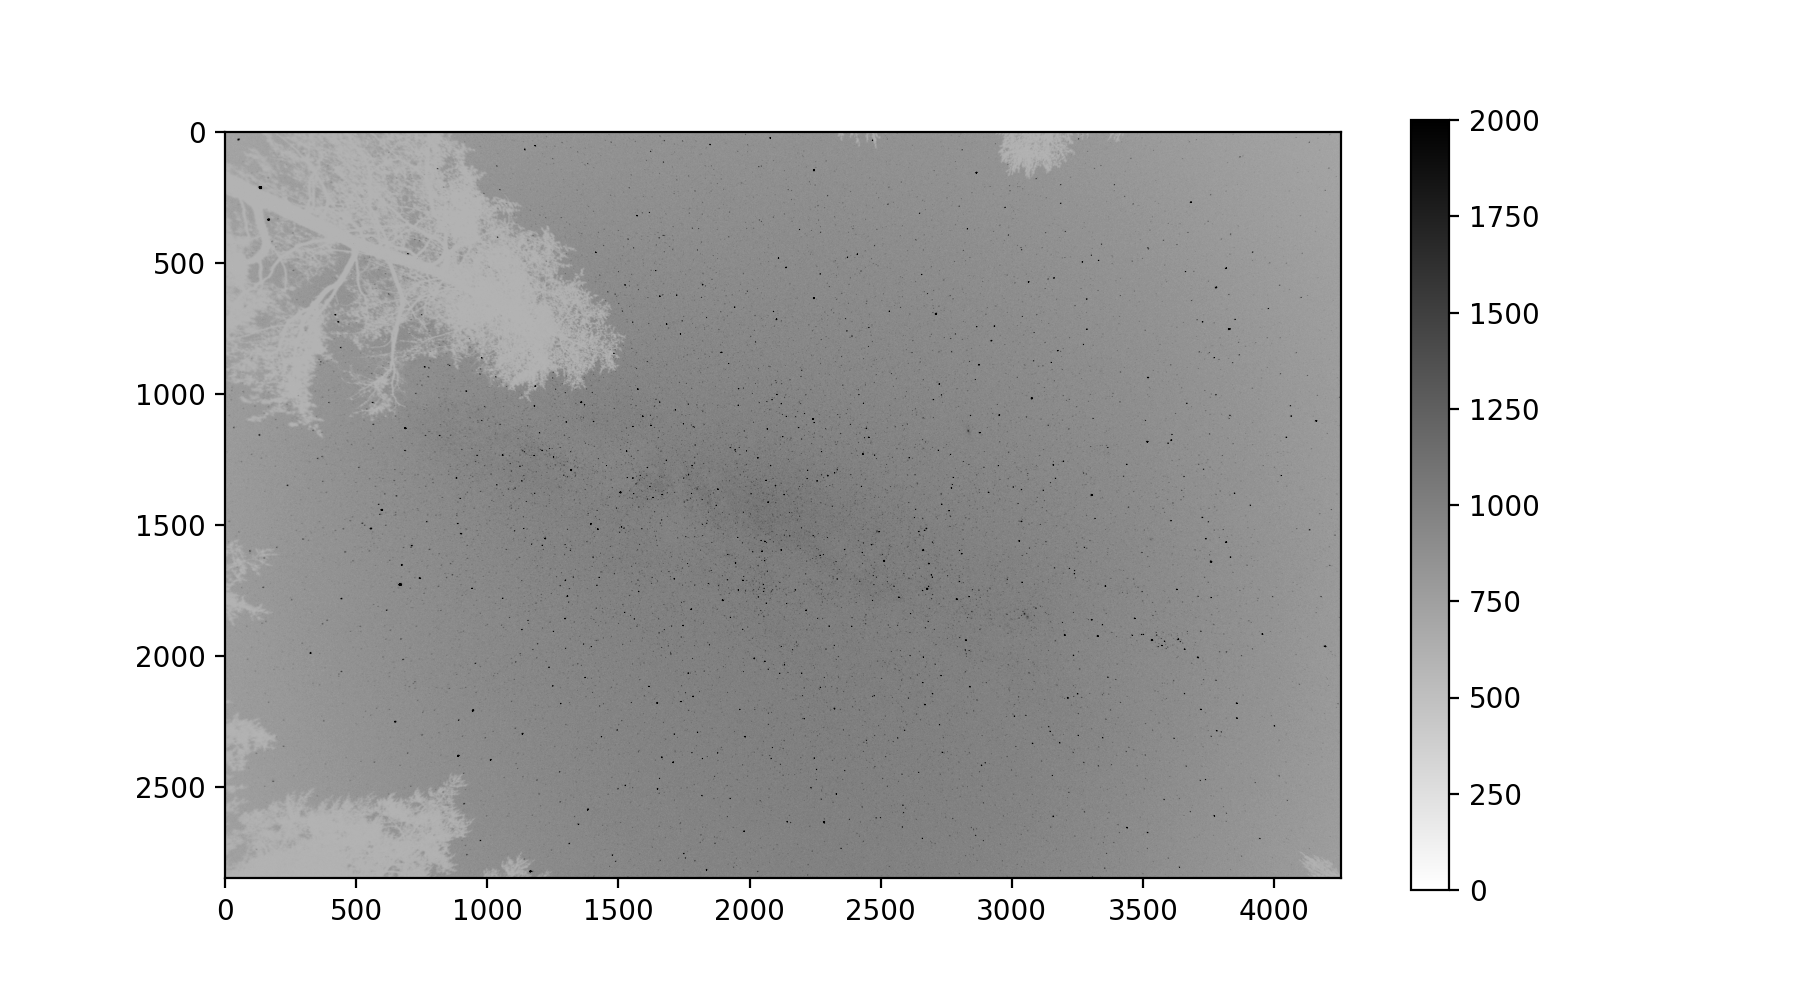

21321.84375
Relative standard deviation of a smooth patch:  0.08636338453617722


In [8]:
plt.figure(figsize=[9, 5])
print(np.max(raw_norm))
plt.imshow(raw_norm, vmin=0, vmax=2000, cmap='binary')
# plt.imshow(raw_norm, vmax=28000, cmap='gist_stern')
plt.colorbar()

section = raw_norm[750:810,3320:3380]
print("Relative standard deviation of a smooth patch: ", np.std(section) / np.median(section))

In [9]:
# estimate background
bkg = Background2D(raw_norm, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

<IPython.core.display.Javascript object>


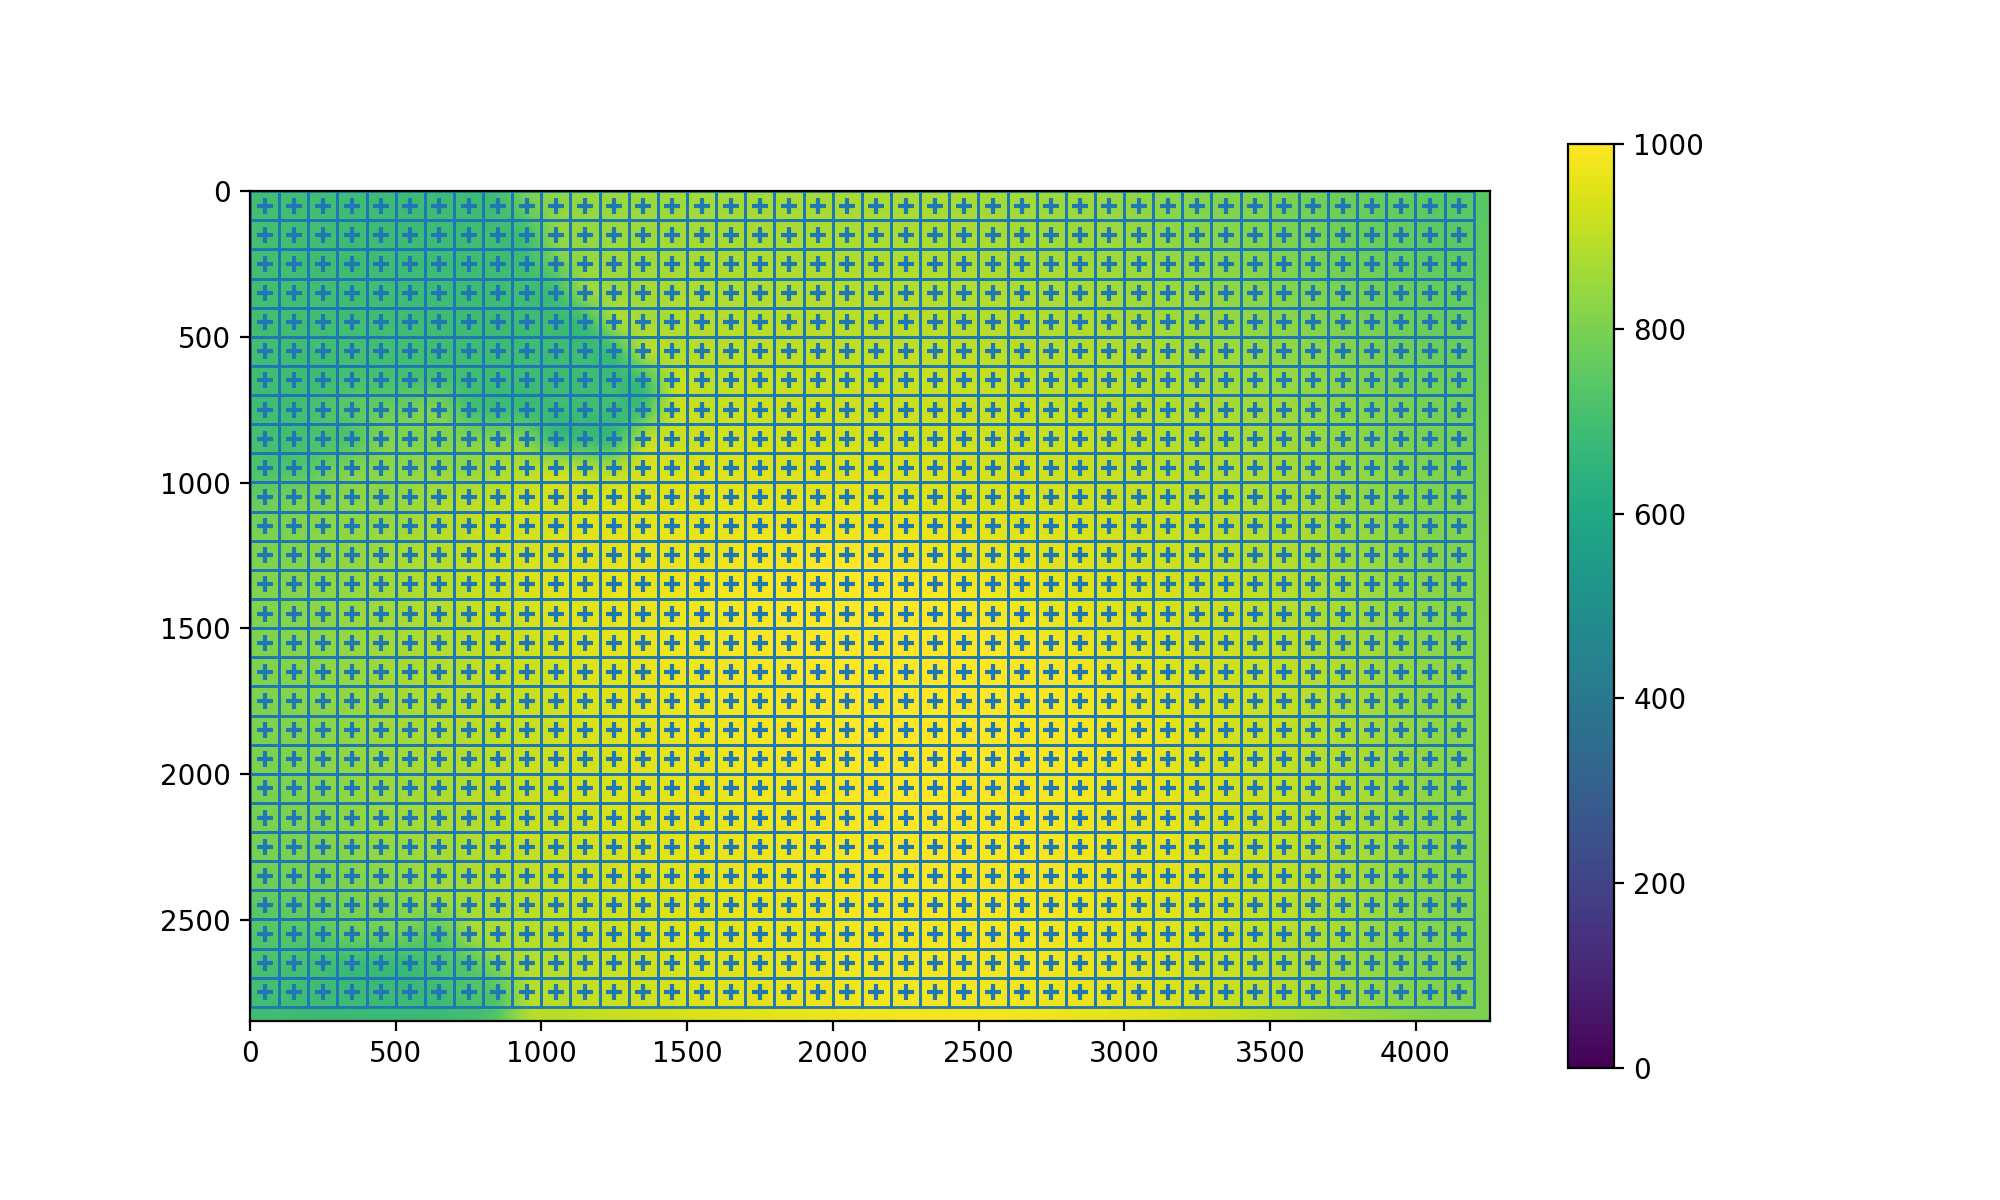

In [10]:
plt.figure(figsize=[10, 6])
plt.imshow(bkg.background, vmin=0, vmax=1000)
bkg.plot_meshes(outlines=True, color='#1f77b4')
plt.colorbar()

In [11]:
subtracted = raw_norm - bkg.background

<IPython.core.display.Javascript object>


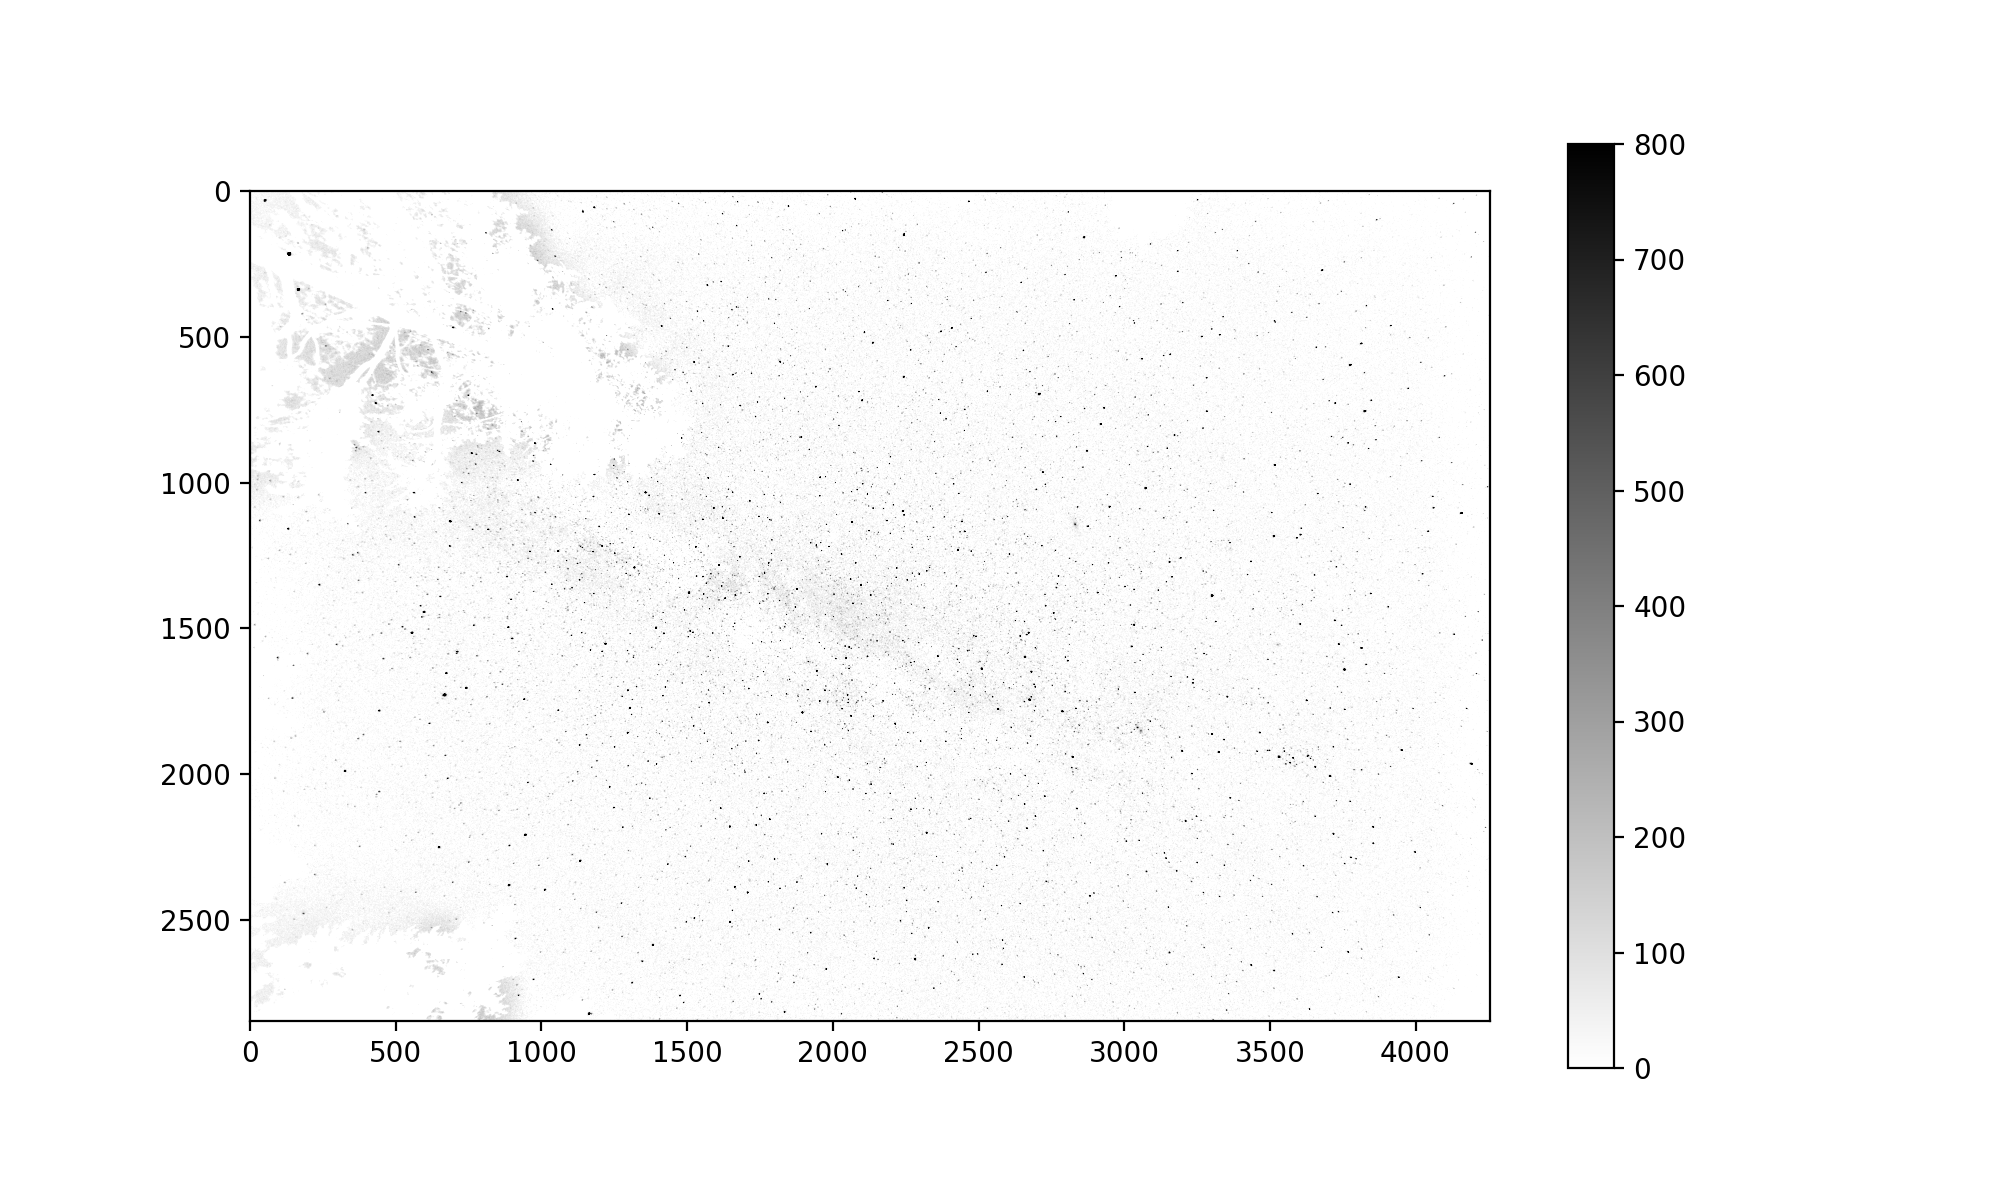

In [12]:
plt.figure(figsize=[10, 6])
plt.imshow(subtracted, vmin=0, vmax=800, cmap='binary')
plt.colorbar()

In [13]:
# find star images
daofind = DAOStarFinder(fwhm=dao_fwhm, threshold=dao_threshold * bkg.background_rms_median)  

# can't be too strict with these. Many images are very non-circular 
# and non-Gaussian due to strong undersampling
#                         sharplo=0.1, sharphi=0.8,
#                         roundlo=-0.7, roundhi=0.7,

sources = daofind(subtracted)  

In [14]:
for col in sources.colnames:  
    sources[col].info.format = '%.4g'  # for consistent table output
print(sources)  

 id  xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag   
---- --------- --------- --------- ---------- ... --- --------- ----- --------
   1      2169     4.002    0.7567     0.3914 ...   0      1665 1.749  -0.6071
   2      1983     12.24    0.6502     0.6185 ...   0      1345 1.492  -0.4343
   3      1657     18.49    0.8794     0.4014 ...   0      1825 1.758  -0.6128
   4      4081     24.36    0.7313    -0.4786 ...   0     974.5 1.143  -0.1446
   5      2077     25.77    0.7395     0.4414 ...   0 1.184e+04 13.27   -2.807
   6     49.89     30.94     0.321    -0.5902 ...   0      2534 3.458   -1.347
   7      49.3     34.56     0.476    -0.1429 ...   0      1186 1.074 -0.07727
   8      2467     34.86    0.4616    0.08791 ...   0      7165 10.96   -2.599
   9      1673     35.86    0.6333     0.9116 ...   0      2629 3.107   -1.231
  10      1563     39.08    0.6514     0.3767 ...   0      1102 1.352  -0.3275
 ...       ...       ...       ...        ... ... ..

In [15]:
# statistics
print("Mean roundness: ", np.average(sources['roundness1']), "stdev: ", np.std(sources['roundness1']))
print("Mean sharpness: ", np.average(sources['sharpness']), "stdev: ", np.std(sources['sharpness']))

Mean roundness:  -0.01723387731713062 stdev:  0.37480400797923763
Mean sharpness:  0.6768454872510835 stdev:  0.2113041259552007


<IPython.core.display.Javascript object>


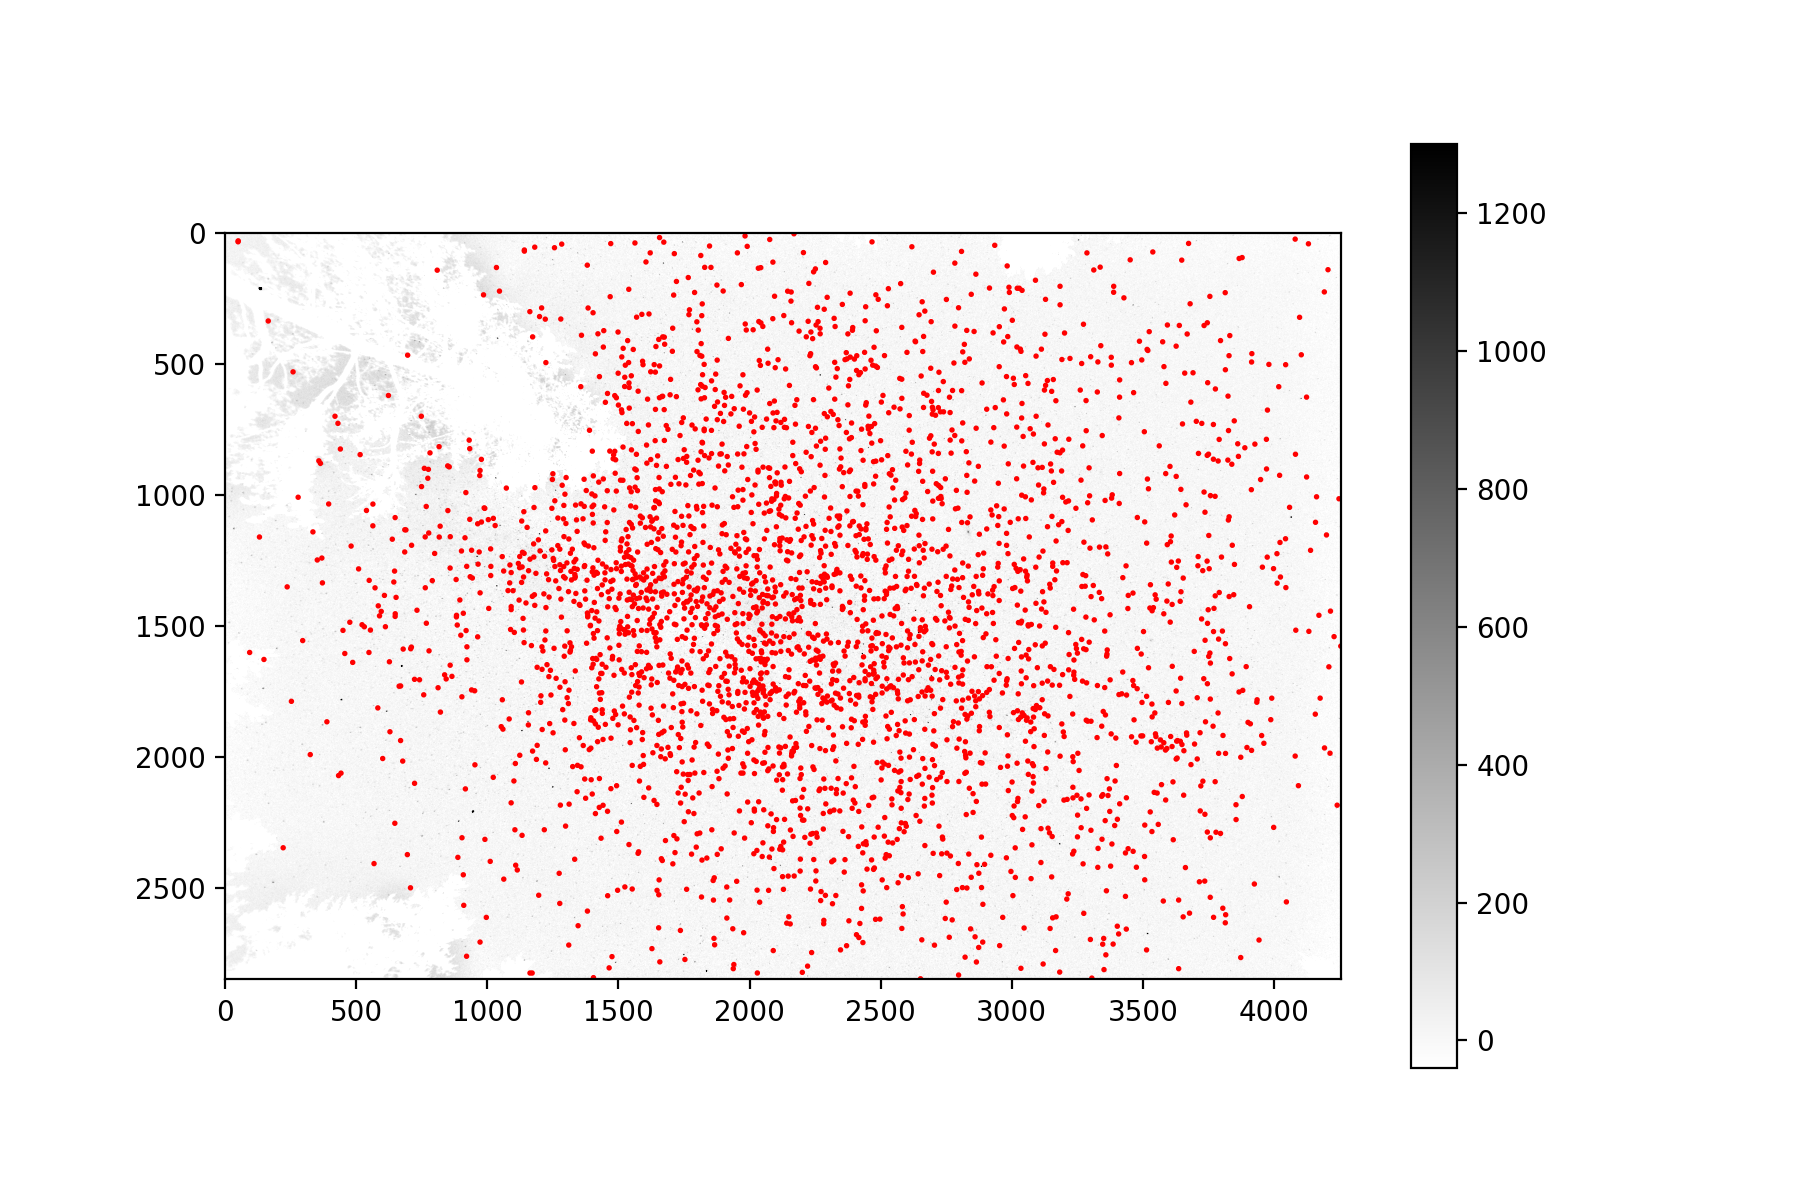

In [16]:
positions = [(x,y) for x,y in zip(sources['xcentroid'], sources['ycentroid'])]
apertures = CircularAperture(positions, r=5.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap = apertures.plot(color='red')

## Statistical analysis

These notebook cells (normally not executed) are used to find optimal R and B normalization factors that would minimize roudness (or maximize sharpness).

In [17]:
# optimization functions
def stats(table):
    mean_roundness = np.average(table['roundness1'])
    mean_sharpness = np.average(table['sharpness'])
    
    print(mean_roundness, mean_shapness)

    return abs(mean_roundness)
#     return 1./ mean_sharpness   # maximum shapness

def objective_function(coeffs):
    
    red_norm = coeffs[0]
    blue_norm = coeffs[1]
    
    raw_norm_1 = imarray * (red_mask * red_norm)
    raw_norm_2 = raw_norm_1 + imarray * (green_mask * 1.0)
    raw_norm = raw_norm_2 + imarray * (blue_mask * blue_norm)
    
    raw_norm = np.where(imarray > 16380, imarray, raw_norm)
    
    bkg = Background2D(raw_norm, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    subtracted = raw_norm - bkg.background
    
    daofind = DAOStarFinder(fwhm=dao_fwhm, threshold=dao_threshold * bkg.background_rms_median)  
    sources = daofind(subtracted)
    
    return stats(sources)  

In [18]:
# res = minimize(objective_function, (1.3, 1.3), method='Nelder-Mead', tol=1e-2)
# print(res.x, res.fun)

### Conclusion

It appears that optimizing for sharpness or roundness doesn't lead to any significant gain in star image conditioning. Too high sharpness causes star images to become crosses. Too low roundness discards a lot of apparently good star images. 

Assuming that DAOfind is optimizing for a Gaussian profile, we can safely assume that the best approach is to optimize for minimum background scatter and leave it at that.

## Correlate two contiguous images

In [19]:
# this is the next image after the test image used at the beginning of the notebook
fname2 = '../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03780.ARW'
raw2 = rawpy.imread(fname2)
imarray2 = raw2.raw_image_visible.astype(float)

In [20]:
# normalize
raw_norm_1_2 = imarray2 * (red_mask * red_norm)
raw_norm_2_2 = raw_norm_1_2 + imarray2 * (green_mask * 1.0)
raw_norm2 = raw_norm_2_2 + imarray2 * (blue_mask * blue_norm)

# handle saturated pixels
raw_norm2 = np.where(imarray2 > 16380, imarray2, raw_norm2)

# compute and subtract background
bkg2 = Background2D(raw_norm2, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
subtracted2 = raw_norm2 - bkg2.background

# find stars
positions = [(x,y) for x,y in zip(sources['xcentroid'], sources['ycentroid'])]
daofind = DAOStarFinder(xycoords=np.array(positions), 
                        fwhm=dao_fwhm, threshold=dao_threshold * bkg2.background_rms_median) 
# daofind = DAOStarFinder(fwhm=dao_fwhm, threshold=dao_threshold * bkg2.background_rms_median) 
sources2 = daofind(subtracted2)

In [21]:
for col in sources2.colnames:  
    sources2[col].info.format = '%.4g'  # for consistent table output
print(sources2)  

 id  xcentroid ycentroid sharpness roundness1 ... npix sky  peak  flux    mag   
---- --------- --------- --------- ---------- ... ---- --- ----- ------ --------
   1      2169     4.102    0.6262      0.205 ...   25   0  1156  1.254  -0.2459
   2      2076     25.48    0.5664     0.7666 ...   25   0  6299   5.13   -1.775
   3      1672     36.39    0.5009     0.5599 ...   25   0  1193 0.7632   0.2934
   4      3673     40.33    0.5671      0.196 ...   25   0 595.8 0.6543   0.4606
   5      2933     47.79    0.8103    -0.4335 ...   25   0 812.1 0.6482   0.4707
   6      1847     50.51    0.4902     0.7545 ...   25   0  5747  8.143   -2.277
   7      1990     52.02    0.6266     0.4708 ...   25   0 891.1 0.8271   0.2061
   8      1141     65.81    0.7271     0.4922 ...   25   0  1253  0.994 0.006481
   9      1141     70.79    0.9275    -0.0915 ...   25   0  4948  3.679   -1.414
  10      2807     71.39    0.6055     -0.803 ...   25   0  2556  2.925   -1.165
 ...       ...       ...    

<IPython.core.display.Javascript object>


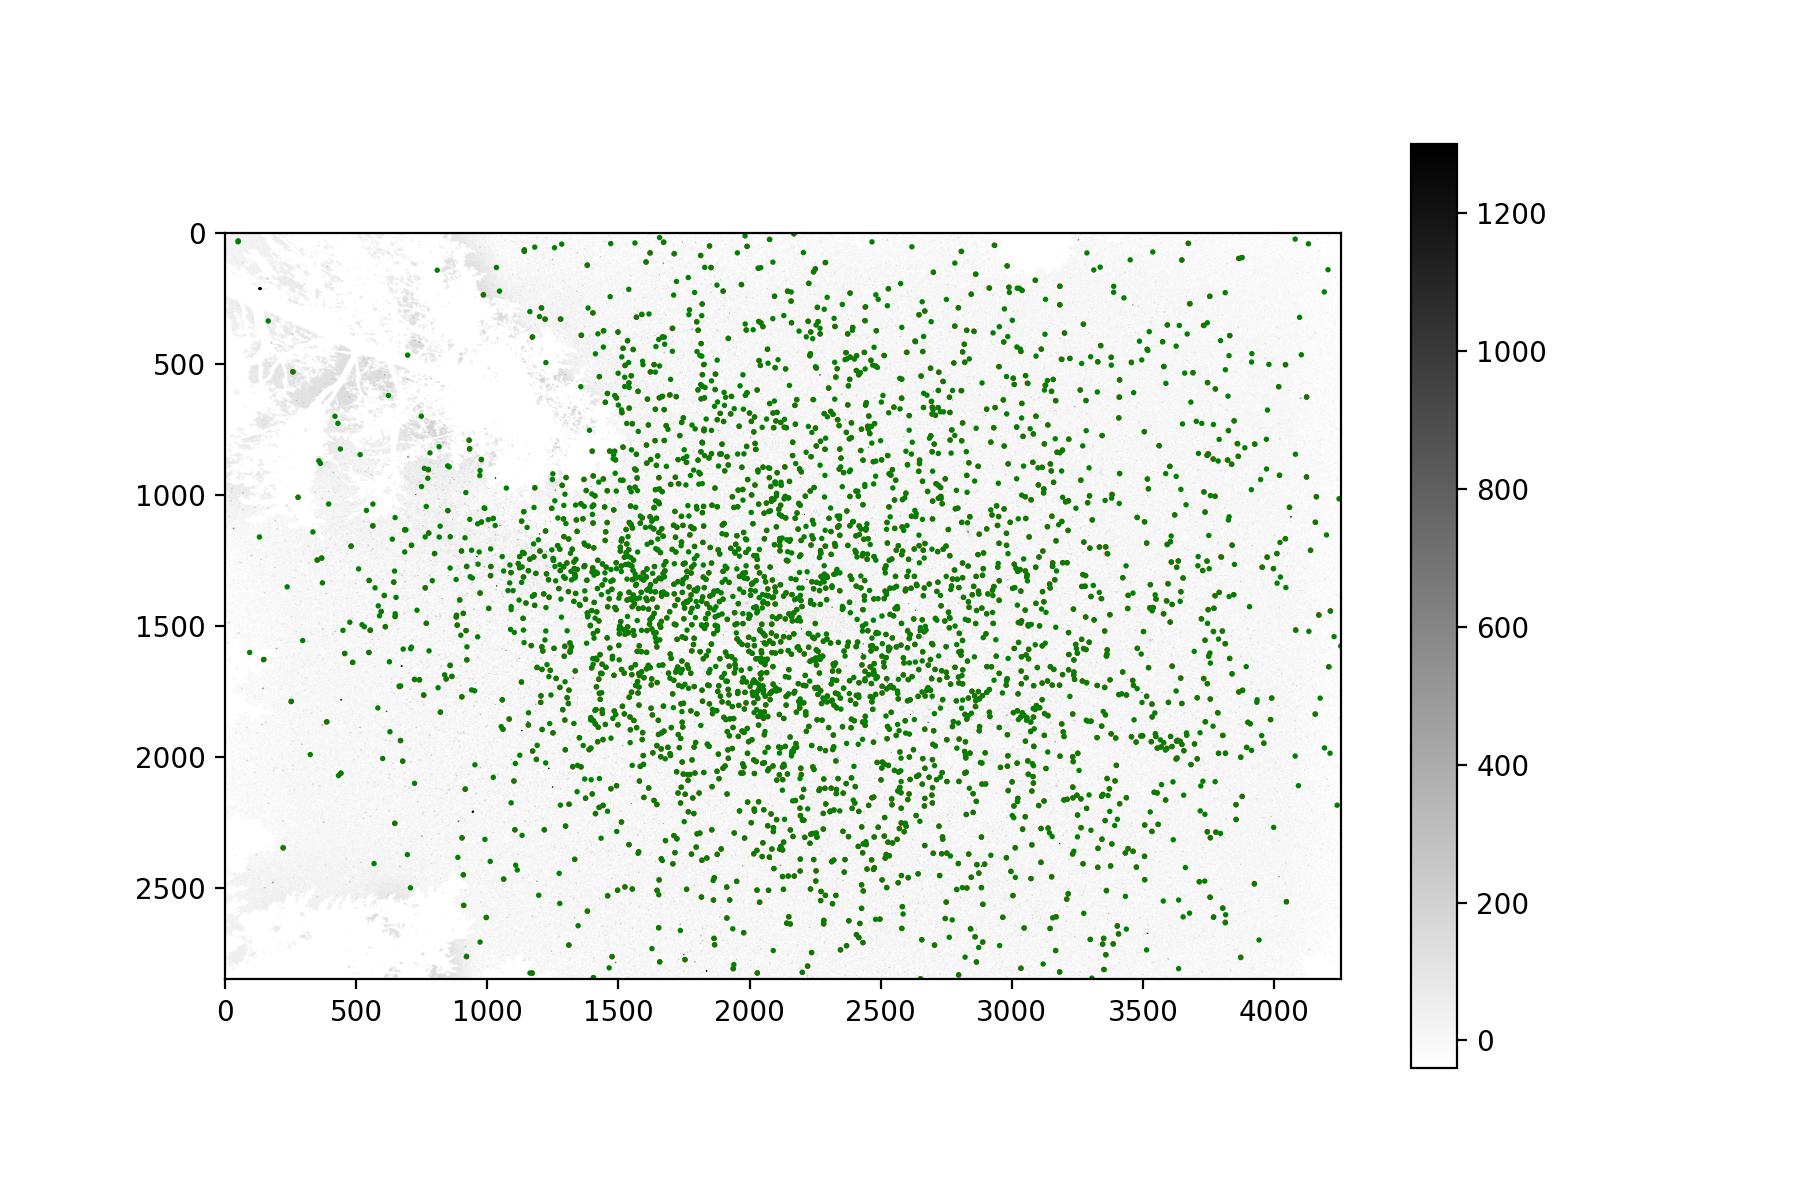

In [22]:
# plot positions from both first and second images
positions2 = [(x,y) for x,y in zip(sources2['xcentroid'], sources2['ycentroid'])]
apertures2 = CircularAperture(positions2, r=5.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted2, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap2 = apertures2.plot(color='red')
ap_ = apertures.plot(color='green') # first image

### Build table with offsets in star positions

First thing to do is to find each pair of stars, one in each table.

For that, we use the centroid positions: for every star in the first table, look for the one star in the second table whose position differs by less than 1.5 pixel (in both X and Y coords).

We also need to store two pointers in the second table. To allow navigation in the list of tables associated to a set of images:

 - the row number of the same star in the reference (first) table.
 - the row number of the same star in the *previous* image in the sequence.
 
The reference image won't have neither of these columns. In the 2nd table in the sequence, these columns will be redundant.

In [23]:
sources2.add_column(np.nan, name='xoffset')
sources2.add_column(np.nan, name='yoffset')
sources2.add_column(0, name='ref_row')
sources2.add_column(0, name='prev_row') # redundant for the 2nd image in sequence

for row_index in range(len(sources)):
    x = sources[row_index]['xcentroid']
    y = sources[row_index]['ycentroid']
    
    for row2_index in range(len(sources2)):
        x2 = sources2[row2_index]['xcentroid']
        y2 = sources2[row2_index]['ycentroid']
        x_off = x2 - x
        y_off = y2 - y
        if abs(x_off) <= 1.5 and abs(y_off) <= 1.5:
            sources2[row2_index]['xoffset'] = x_off
            sources2[row2_index]['yoffset'] = y_off
            sources2[row2_index]['ref_row'] = row_index
            sources2[row2_index]['prev_row'] = row_index
            
            break # if there is another star that matches the criterion, just ignore it

In [24]:
for col in sources2.colnames:  
    sources2[col].info.format = '%.5g'  # for consistent table output
print(sources2)  

 id  xcentroid ycentroid sharpness ...  xoffset    yoffset  ref_row prev_row
---- --------- --------- --------- ... ---------- --------- ------- --------
   1      2169    4.1024    0.6262 ...   -0.41408   0.10014       0        0
   2    2075.9    25.478   0.56639 ...    -1.0809  -0.28871       4        4
   3    1671.8    36.387   0.50093 ...    -1.1551   0.53065       8        8
   4    3672.5     40.33   0.56714 ...        nan       nan       0        0
   5    2933.2    47.788   0.81031 ...        nan       nan       0        0
   6    1847.2    50.505    0.4902 ...   -0.19467  -0.21164      15       15
   7    1990.1    52.024   0.62661 ...   -0.94274  0.051428      16       16
   8    1140.8    65.811    0.7271 ...   -0.42782 -0.046327      20       20
   9    1140.6     70.79   0.92754 ...   -0.53838   0.61326      21       21
  10    2807.3    71.389   0.60554 ...   -0.98241  0.092288      22       22
 ...       ...       ...       ... ...        ...       ...     ...      ...

In [25]:
# stats
print(np.nanmean(sources2['xoffset']), np.nanstd(sources2['xoffset']))
print(np.nanmean(sources2['yoffset']), np.nanstd(sources2['yoffset']))
print(np.count_nonzero(~np.isnan(sources2['xoffset'])))

-0.4171382709164685 0.4351182633356924
-0.007807615206797712 0.45795862995153036
2044


In [26]:
# keep only the NaN-free entries
has_nan = np.zeros(len(sources2), dtype=bool)
xoff = np.array(sources2['xoffset'])
has_nan |= np.isnan(xoff)
sources2_no_nan = sources2[~has_nan]

In [27]:
for col in sources2_no_nan.colnames:  
    sources2_no_nan[col].info.format = '%.5g'  # for consistent table output
print(sources2_no_nan)

 id  xcentroid ycentroid sharpness ...  xoffset    yoffset  ref_row prev_row
---- --------- --------- --------- ... ---------- --------- ------- --------
   1      2169    4.1024    0.6262 ...   -0.41408   0.10014       0        0
   2    2075.9    25.478   0.56639 ...    -1.0809  -0.28871       4        4
   3    1671.8    36.387   0.50093 ...    -1.1551   0.53065       8        8
   6    1847.2    50.505    0.4902 ...   -0.19467  -0.21164      15       15
   7    1990.1    52.024   0.62661 ...   -0.94274  0.051428      16       16
   8    1140.8    65.811    0.7271 ...   -0.42782 -0.046327      20       20
   9    1140.6     70.79   0.92754 ...   -0.53838   0.61326      21       21
  10    2807.3    71.389   0.60554 ...   -0.98241  0.092288      22       22
  11    1620.2    77.098   0.59535 ...   -0.86147   0.24151      25       25
  12    1712.3    80.354    0.3905 ...   -0.79134    0.6313      28       28
 ...       ...       ...       ... ...        ...       ...     ...      ...

<IPython.core.display.Javascript object>


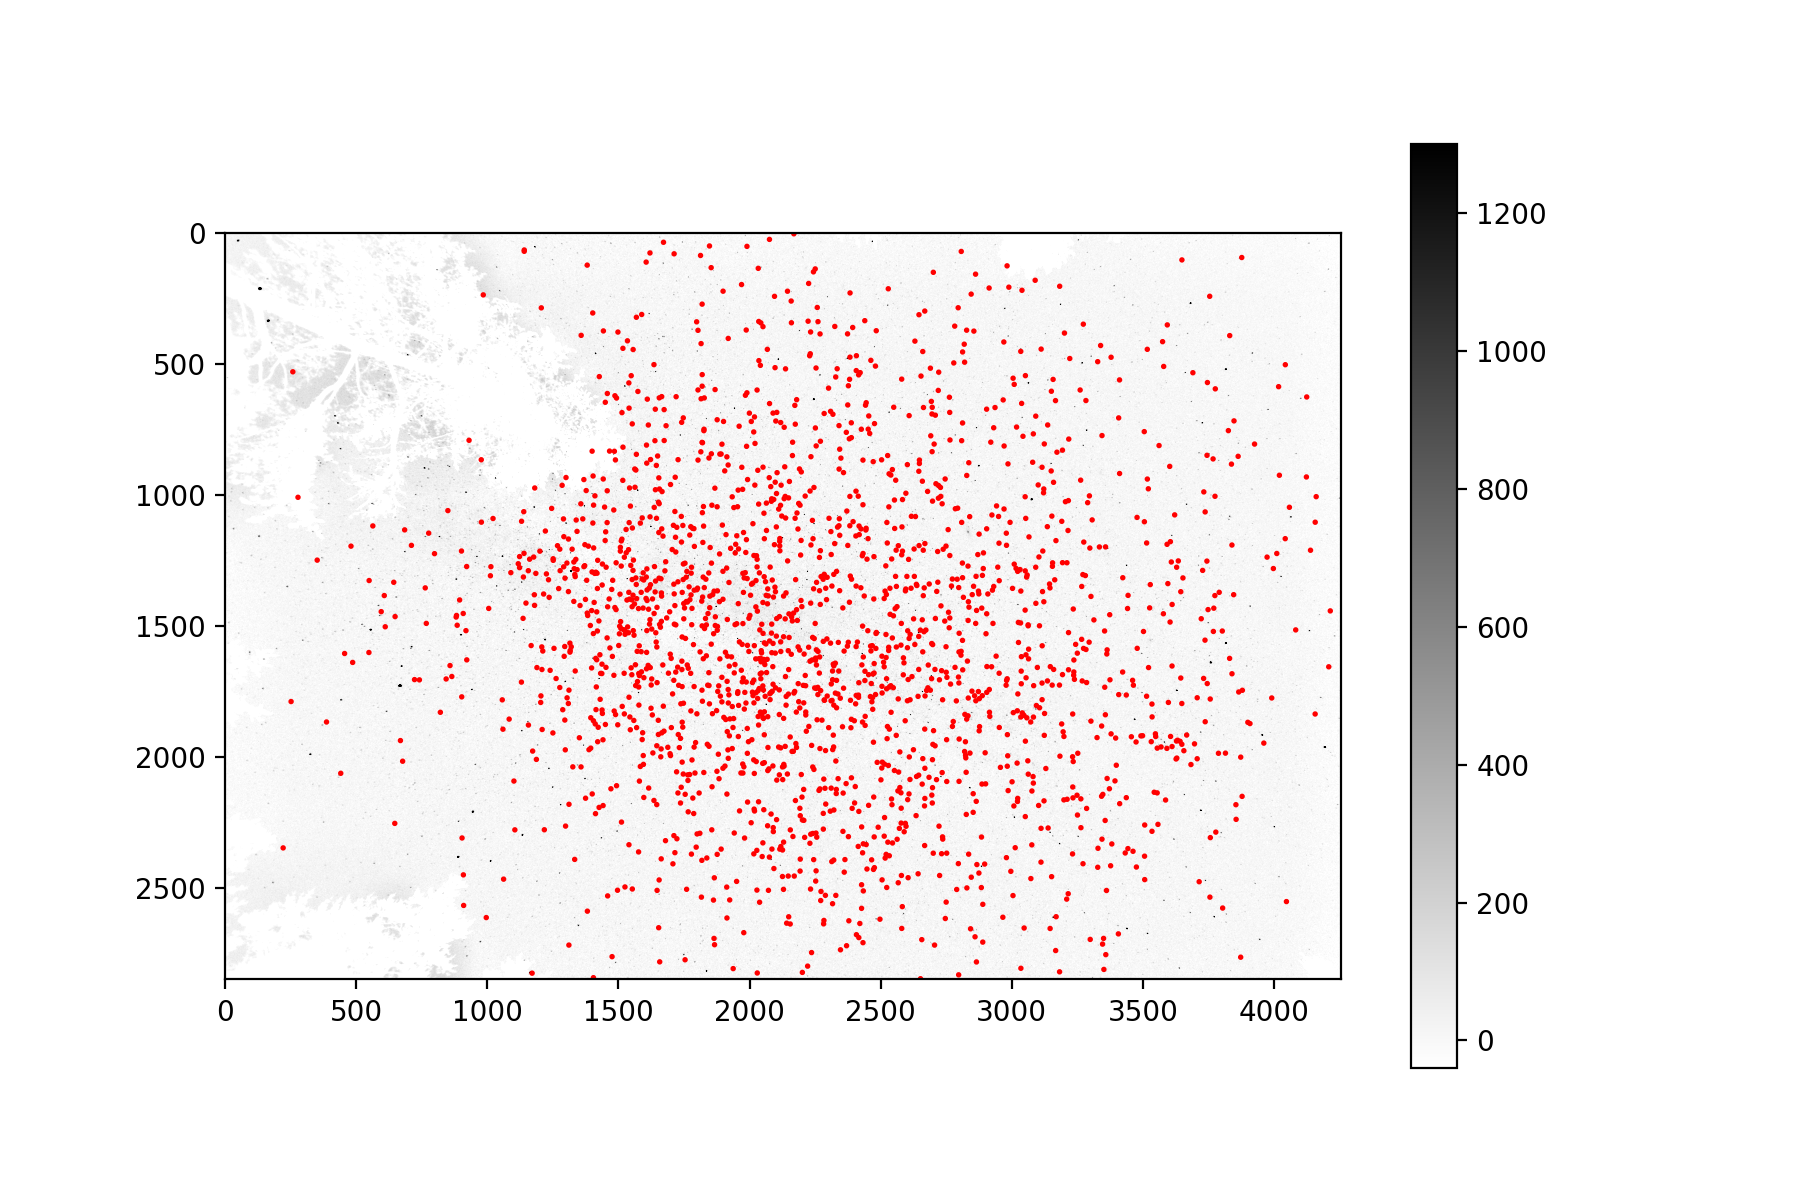

In [28]:
positions2_n = [(x,y) for x,y in zip(sources2_no_nan['xcentroid'], sources2_no_nan['ycentroid'])]
apertures2_n = CircularAperture(positions2_n, r=5.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted2, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap2_n = apertures2_n.plot(color='red')

## Add third image in sequence

The table associated to this image should contain offsets in relation to the first image. But to find star pairs, the code must use the second image. That is, the image immediately before it in the image time sequence.

We may want to add the image name (or path) to the table header.

In [29]:
# this is the next, third image 
fname3 = '../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03781.ARW'
raw3 = rawpy.imread(fname3)
imarray3 = raw3.raw_image_visible.astype(float)

In [30]:
# normalize
raw_norm_1_3 = imarray3 * (red_mask * red_norm)
raw_norm_2_3 = raw_norm_1_3 + imarray3 * (green_mask * 1.0)
raw_norm3 = raw_norm_2_3 + imarray3 * (blue_mask * blue_norm)

# handle saturated pixels
raw_norm3 = np.where(imarray3 > 16380, imarray3, raw_norm3)

# compute and subtract background
bkg3 = Background2D(raw_norm3, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
subtracted3 = raw_norm3 - bkg3.background

# find stars
positions = [(x,y) for x,y in zip(sources2_no_nan['xcentroid'], sources2_no_nan['ycentroid'])]
daofind = DAOStarFinder(xycoords=np.array(positions), 
                        fwhm=dao_fwhm, threshold=dao_threshold * bkg3.background_rms_median) 
# daofind = DAOStarFinder(fwhm=dao_fwhm, threshold=dao_threshold * bkg3.background_rms_median)  
sources3 = daofind(subtracted3)

In [31]:
for col in sources3.colnames:  
    sources3[col].info.format = '%.5g'  # for consistent table output
print(sources3)  

 id  xcentroid ycentroid sharpness roundness1 ... sky  peak    flux    mag   
---- --------- --------- --------- ---------- ... --- ------ ------- --------
   1    2074.8    26.651   0.84187   -0.80827 ...   0 7454.5  5.4986  -1.8506
   2    1845.2    50.677   0.52836    0.17732 ...   0 3466.1  3.4993    -1.36
   3    1989.3    52.147   0.20729    0.44691 ...   0  661.8  1.2893 -0.27584
   4    2806.7    71.629    0.5156   -0.53792 ...   0 2792.3  3.9548  -1.4928
   5    1619.3    77.552   0.58803    0.57347 ...   0 2208.3  2.2961 -0.90248
   6    1812.3    86.781   0.49979    0.28239 ...   0 583.57 0.78359  0.26478
   7    2033.8    135.07    0.6654    0.76143 ...   0 1152.7 0.59442  0.56477
   8    2861.2    157.89   0.36513   -0.72925 ...   0  16149  20.934  -3.3021
   9    3088.6    181.22   0.72531   -0.43789 ...   0 3508.1  4.0762  -1.5256
  10    2224.7    193.64   0.32954   -0.12141 ...   0 738.33  1.2131 -0.20974
 ...       ...       ...       ...        ... ... ...    ...    

Here we do the more general table operation to correlate the positions just gotten from the 3rd image, with the positions from the second image. But storing offsets in relation to the first (reference) image.

In [32]:
sources3.add_column(np.nan, name='xoffset')
sources3.add_column(np.nan, name='yoffset')
sources3.add_column(0, name='ref_row')
sources3.add_column(0, name='prev_row')

# loop over rows in 2nd table
for row_index2 in range(len(sources2_no_nan)):
    # get position in 2nd table, and index in 1st table
    x2 = sources2_no_nan[row_index2]['xcentroid']
    y2 = sources2_no_nan[row_index2]['ycentroid']
    ref_row = sources2_no_nan[row_index2]['ref_row']
    
    if ref_row == 0:
        continue

    # loop over rows in 3rd (newest) table
    for row_index3 in range(len(sources3)):
        x3 = sources3[row_index3]['xcentroid']
        y3 = sources3[row_index3]['ycentroid']
        
        # offsets in relation to 2nd table - these are the ones to check for proximity
        x32_off = x3 - x2
        y32_off = y3 - y2
        
        # offsets in relation to reference table
        x_ref = sources[ref_row]['xcentroid']
        y_ref = sources[ref_row]['ycentroid']
        x_off = x3 - x_ref
        y_off = y3 - y_ref

        if abs(x32_off) <= 1.5 and abs(y32_off) <= 1.5:
            sources3[row_index3]['xoffset'] = x_off
            sources3[row_index3]['yoffset'] = y_off
            
            # store pointers to rows in reference and previous tables
            sources3[row_index3]['ref_row'] = ref_row
            sources3[row_index3]['prev_row'] = row_index2
            
            break # if there is another star that matches the criterion, just ignore it

In [33]:
for col in sources3.colnames:  
    sources3[col].info.format = '%.5g'  # for consistent table output
print(sources3)  

 id  xcentroid ycentroid sharpness ... xoffset  yoffset  ref_row prev_row
---- --------- --------- --------- ... -------- -------- ------- --------
   1    2074.8    26.651   0.84187 ...   -2.154  0.88405       4        1
   2    1845.2    50.677   0.52836 ...      nan      nan       0        0
   3    1989.3    52.147   0.20729 ...  -1.7447   0.1747      16        4
   4    2806.7    71.629    0.5156 ...  -1.5452  0.33232      22        7
   5    1619.3    77.552   0.58803 ...   -1.772  0.69502      25        8
   6    1812.3    86.781   0.49979 ...  -1.7235 -0.05588      29       10
   7    2033.8    135.07    0.6654 ...  0.34782 -0.29916      45       17
   8    2861.2    157.89   0.36513 ...  -1.8721 -0.21011      52       21
   9    3088.6    181.22   0.72531 ...  -1.6699 0.034905      54       22
  10    2224.7    193.64   0.32954 ...  -1.4298  0.40308      56       23
 ...       ...       ...       ... ...      ...      ...     ...      ...
1190    3872.3    2762.4     0.376 ...

In [34]:
# keep only the NaN-free entries
has_nan = np.zeros(len(sources3), dtype=bool)
xoff = np.array(sources3['xoffset'])
has_nan |= np.isnan(xoff)
sources3_no_nan = sources3[~has_nan]

In [35]:
for col in sources3_no_nan.colnames:  
    sources3_no_nan[col].info.format = '%.5g'  # for consistent table output
print(sources3_no_nan)  

 id  xcentroid ycentroid sharpness ... xoffset  yoffset  ref_row prev_row
---- --------- --------- --------- ... -------- -------- ------- --------
   1    2074.8    26.651   0.84187 ...   -2.154  0.88405       4        1
   3    1989.3    52.147   0.20729 ...  -1.7447   0.1747      16        4
   4    2806.7    71.629    0.5156 ...  -1.5452  0.33232      22        7
   5    1619.3    77.552   0.58803 ...   -1.772  0.69502      25        8
   6    1812.3    86.781   0.49979 ...  -1.7235 -0.05588      29       10
   7    2033.8    135.07    0.6654 ...  0.34782 -0.29916      45       17
   8    2861.2    157.89   0.36513 ...  -1.8721 -0.21011      52       21
   9    3088.6    181.22   0.72531 ...  -1.6699 0.034905      54       22
  10    2224.7    193.64   0.32954 ...  -1.4298  0.40308      56       23
  11    3181.4       204   0.86253 ...   -2.642 -0.18614      60       25
 ...       ...       ...       ... ...      ...      ...     ...      ...
1189    2237.4    2745.3   0.61633 ...

In [36]:
# stats
print(np.nanmean(sources3_no_nan['xoffset']), np.nanstd(sources3_no_nan['xoffset']))
print(np.nanmean(sources3_no_nan['yoffset']), np.nanstd(sources3_no_nan['yoffset']))
print(np.count_nonzero(~np.isnan(sources3_no_nan['xoffset'])))

-0.728634645525164 0.5507289378874177
-0.018590285129631904 0.5615606603407052
1084


<IPython.core.display.Javascript object>


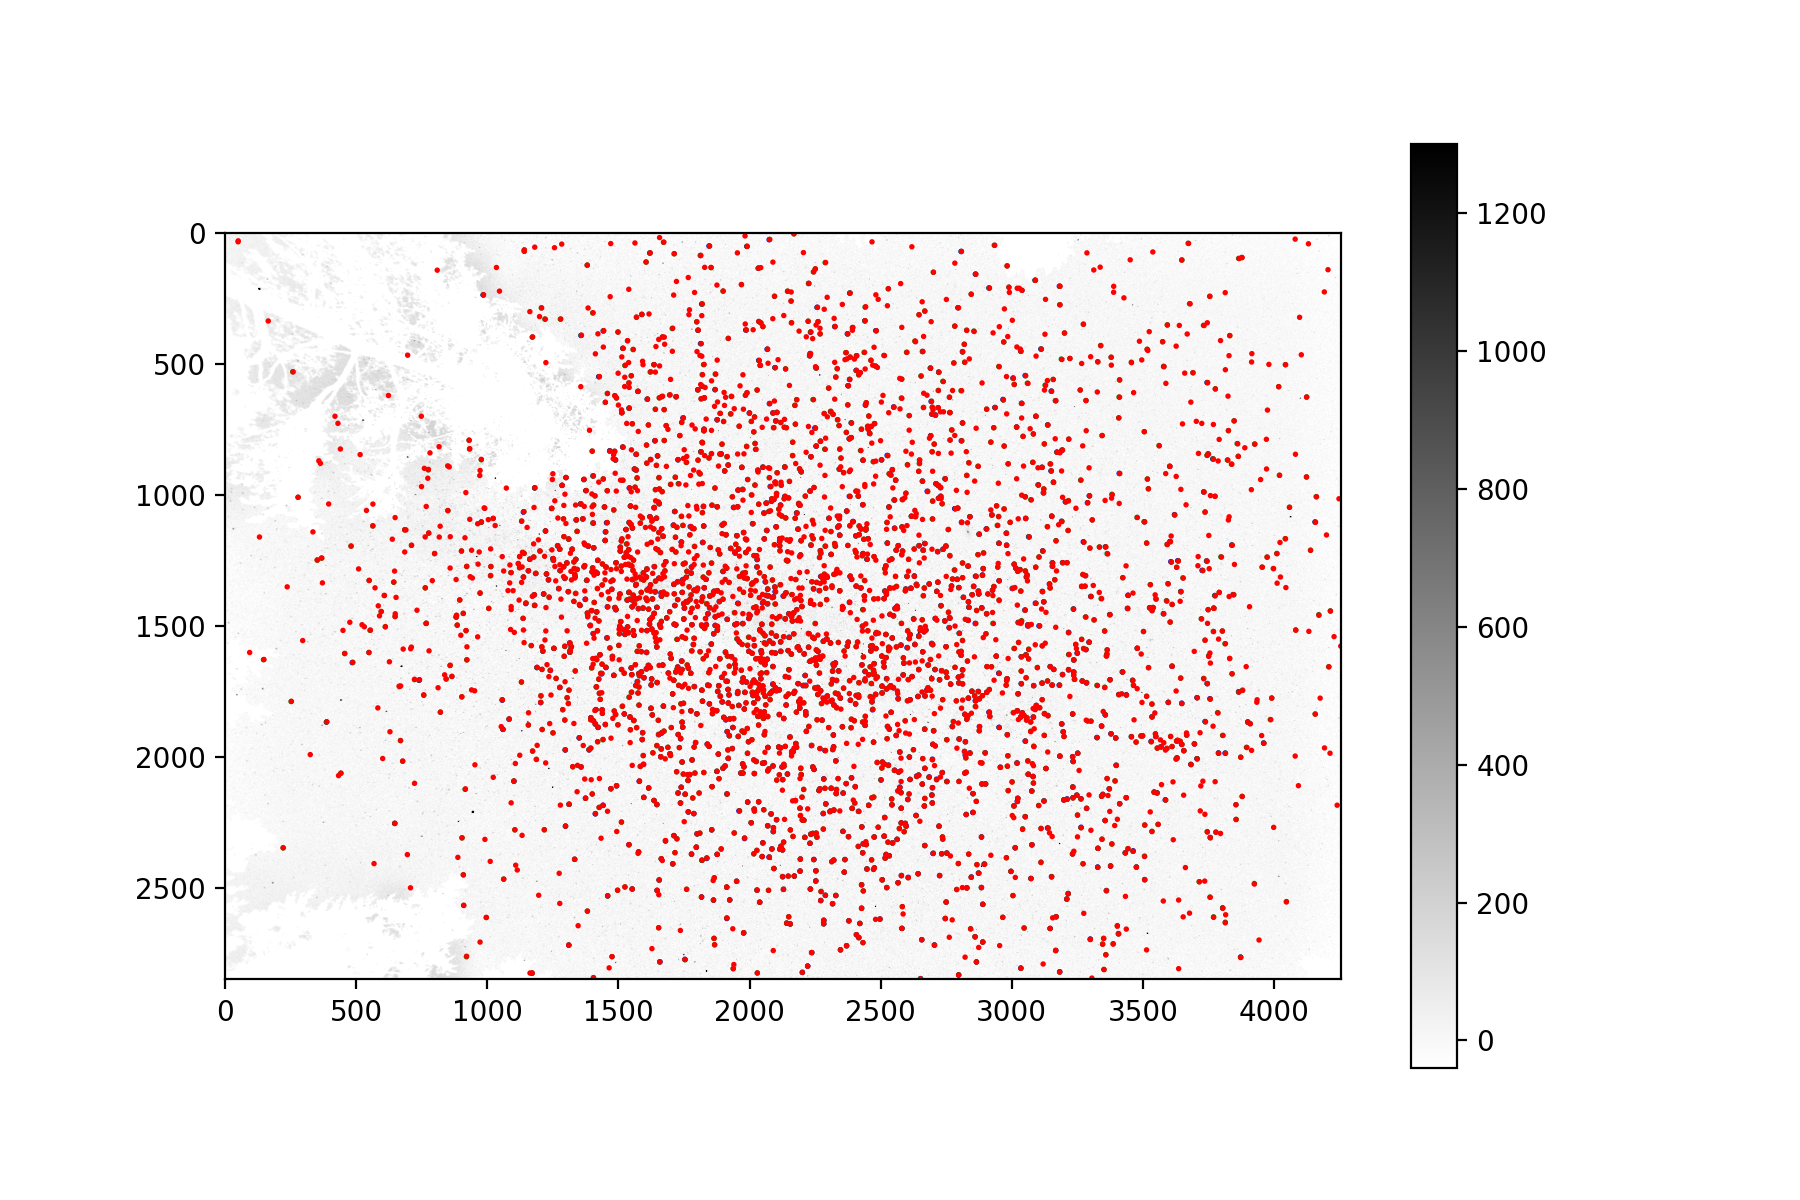

In [37]:
# plot positions from 3 images
positions3 = [(x,y) for x,y in zip(sources3['xcentroid'], sources3['ycentroid'])]
apertures3 = CircularAperture(positions3, r=5.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted3, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap3 = apertures3.plot(color='blue')
ap2 = apertures2.plot(color='green') 
ap1 = apertures.plot(color='red') 

## Save to file

In [38]:
sources3_no_nan.write('table.fits', format='fits', overwrite=True)

In [39]:
test = Table.read('table.fits')